# Plot wind data from Neah Bay DFO buoy 46206

About 50 km north of Barkley Canyon

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import scipy.signal as sig
import scipy.misc as deriv
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [2]:
# import data

ds = xr.open_dataset(f'../../../Data/wind/wind.nc')
    
#print(ds)

In [3]:
# select data

year = 2018
t_stamp = f'{year}'
start_date = np.datetime64(f'{year}-01-01')
end_date = np.datetime64(f'{year+1}-01-01')

if year == 2013:
    dt_tot = ds.dt2013
    wdir_tot = ds.wdir2013
    wspd_tot = ds.wspd2013
elif year == 2014:
    dt_tot = ds.dt2014
    wdir_tot = ds.wdir2014
    wspd_tot = ds.wspd2014
elif year == 2017:
    dt_tot = ds.dt2017
    wdir_tot = ds.wdir2017
    wspd_tot = ds.wspd2017
elif year == 2018:
    dt_tot = ds.dt2018
    wdir_tot = ds.wdir2018
    wspd_tot = ds.wspd2018

In [4]:
# get data segments in lists

if year == 2013:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg = 1
elif year == 2014:
    dt0 = dt_tot[:621]
    dt1 = dt_tot[621:]
    dt = [dt0,dt1]
    wspd0 = wspd_tot[:621]
    wspd1 = wspd_tot[621:]
    wspd = [wspd0,wspd1]
    wdir0 = wdir_tot[:621]
    wdir1 = wdir_tot[621:]
    wdir = [wdir0,wdir1]
    n_seg = 2
elif year == 2017:
    dt0 = dt_tot[:3974]
    dt1 = dt_tot[4100:5017]
    dt2 = dt_tot[5080:]
    dt = [dt0,dt1,dt2]
    wspd0 = wspd_tot[:3974]
    wspd1 = wspd_tot[4100:5017]
    wspd2 = wspd_tot[5080:]
    wspd = [wspd0,wspd1,wspd2]
    wdir0 = wdir_tot[:3974]
    wdir1 = wdir_tot[4100:5017]
    wdir2 = wdir_tot[5080:]
    wdir = [wdir0,wdir1,wdir2]
    n_seg = 3
elif year == 2018:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg = 1

## Pumping extension (outlined by Voelker et al., 2020)

In [5]:
# get horizontal mixed layer velocity components

# import data

ds_in = xr.open_dataset(f'../../../Data/wind/ml_currents_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    dsw = [ds_in]
    for i in range(n_seg):
        if i > 0:
            dsw_temp = xr.open_dataset(f'../../../Data/wind/ml_currents_{year}_{i}.nc')
            dsw.append(dsw_temp)
elif n_seg == 1:
    dsw = [ds_in]

In [6]:
# vertical near-inertial energy transfer parameters

Nmix = 2.52e-3        # base of mixed layer N [Hz]
cor = 1.74e-5         # local Coriolis parameter [Hz]
L = 400               # length scale, from paper (in km???)
roh = 1024            # avg density of mixed layer seawater from N2 calculations (similar for either season)
D = []
for i in range(n_seg):
    Dtemp = dsw[i].H.values             # depth of mixed layer through time
    D.append(Dtemp)

In [7]:
# band pass around f (not needed?)

# ubp,vbp = [],[]   # empty lists for filtered data
# fs = 2.777e-4                               # samples per SECOND for entire time series
# Wn = [1.35e-5,2.00e-5]                      # cut-off frequencies
# sos = sig.butter(8, Wn,'bandpass', fs=fs, output='sos')   # digital butterworth filter
# w,h = sig.sosfreqz(sos) 
# #plt.semilogx(w*fs/(2*np.pi),abs(h))

# for i in range(n_seg):
#     ufilt = np.copy(Zu[i])       # copy unfiltered array
#     ubp_temp = sig.sosfiltfilt(sos, ufilt)    # apply band pass filter
#     vfilt = np.copy(Zv[i])       # repeat for v
#     vbp_temp = sig.sosfiltfilt(sos, vfilt)
#     ubp.append(ubp_temp)
#     vbp.append(vbp_temp)

In [8]:
# get depth-integrated vertical velocities from NI mixed layer horizontal velocities

def divergence(f):
    """
    Computes the divergence of a vector field at point f, corresponding to du/dt + dv/dt
    :param f: List of TWO ndarrays, where every item of the list is one dimension of the vector field (u, v)
    :return: Single ndarray of the same shape as each of the items in f, with scalar output
    """
    a = np.gradient(f[0],3600)
    b = np.gradient(f[1],3600)
    ab = np.sum([a,b],axis=0)
    return ab

wxDt = []
for i in range(n_seg):
    div = divergence([dsw[i].Zu.values,dsw[i].Zv.values])
    wxDt_temp_list = []
    for j in range(div.size):
        wxDt_temp = D[i][j]*div[j]             # depth-integrated vertical velocities in mixed layer
        wxDt_temp_list.append(wxDt_temp)
    wxDt.append(wxDt_temp_list)

In [9]:
# remove mean

wm = []
for i in range(n_seg):
    wm_temp = np.copy(wxDt[i]) - np.nanmean(wxDt[i])
    wm.append(wm_temp)     # list[segment][depth][time]

In [10]:
# get spectrogram

fs = 2.7777778e-4
win = 'hanning'
nps = 256
overlap=0.9*nps

Sw,fw,ftw = [],[],[]
for i in range(n_seg):
    w_f, w_t, w_Sxx = sig.spectrogram(wm[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
    
    # convert spectro_t to datetime for x-axis on plots for PSD
    spectro_t4 = w_t*fs
    spectro_time_len = len(spectro_t4)
    spectro_time_axis = np.zeros([spectro_time_len],dtype='datetime64[s]')
    for k in range(spectro_time_len):
        j = int(spectro_t4[k])
        spectro_time_axis[k] = dsw[i].time[j].values
        
    Sw.append(w_Sxx)
    fw.append(w_f)
    ftw.append(spectro_time_axis)

In [11]:
# get h(omega) frequency window

homega = []
for i in range(n_seg):
    wfreq = fw[i]
    Fomega = (1 / wfreq[17:]) * np.sqrt((Nmix**2) - (wfreq[17:]**2)) * np.sqrt((wfreq[17:]**2) - (cor**2))
    homega_temp = np.sqrt(Fomega / (Nmix - cor))
    homega_full = np.insert(homega_temp,0,np.zeros(17))
    homega.append(homega_full)

In [12]:
# apply window

Sww = []
for i in range(n_seg):
    Swj = []
    for j in range(len(homega[i])):
        Sww_win = Sw[i][j] * (homega[i][j]**2)
        Swj.append(Sww_win)
    Sww.append(Swj)

In [13]:
# get vertical energy flux

psiNI = []
for i in range(n_seg):
    Swwnp = np.asarray(Sww[i])
    psiNI_coeff = -roh * (L / (2*np.pi)) * (Nmix - cor)
    psiNI_temp = psiNI_coeff * Swwnp
    psiNI.append(psiNI_temp)

In [14]:
# integrate at each time step

IW_int = []

for i in range(n_seg):
    IW_int_temp = []
    SIW_np = np.copy(psiNI[i])
    for j in range(len(SIW_np[0,:])):      
        IW_int_temp.append(np.trapz(y=SIW_np[:,j],x=fw[i][:]))
    IW_int.append(np.asarray(IW_int_temp))

NI_int = []

for i in range(n_seg):
    NI_int_temp = []
    SNI_np = np.copy(psiNI[i])
    for j in range(len(SNI_np[0,:])):      
        NI_int_temp.append(np.trapz(y=SNI_np[14:19,j],x=fw[i][14:19]))
    NI_int.append(np.asarray(NI_int_temp))

<IPython.core.display.Javascript object>


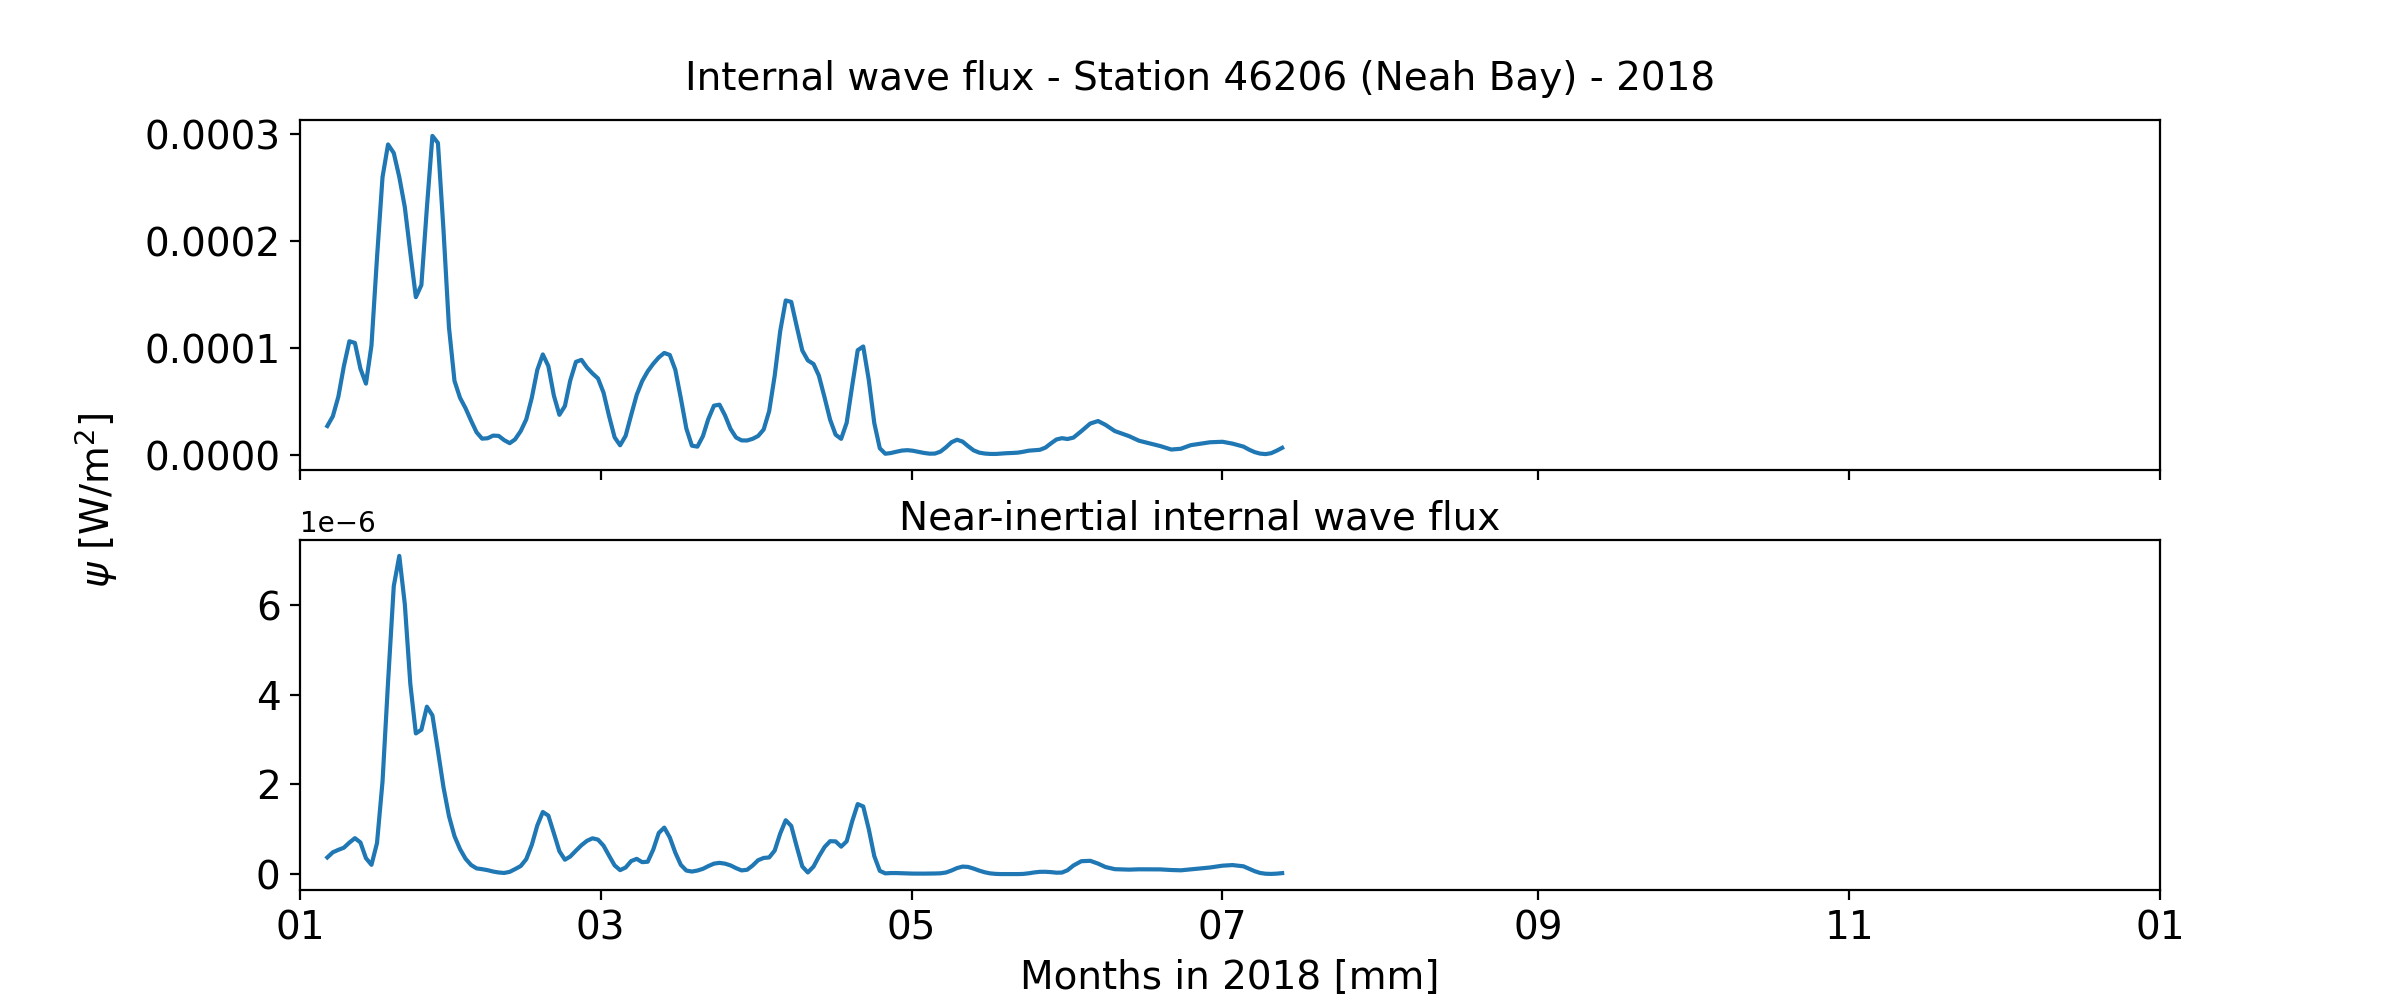

In [15]:
# plot band-passed integrated rotary data

fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,5),sharex=True)
fig.text(0.5, 0.91, f'Internal wave flux - Station 46206 (Neah Bay) - {t_stamp}', ha='center', fontsize=14)
fig.text(0.5, 0.47, f'Near-inertial internal wave flux', ha='center', fontsize=14)

for i in range(n_seg):
    ax0.plot(ftw[i],abs(IW_int[i]),color='tab:blue')
    ax1.plot(ftw[i],abs(NI_int[i]),color='tab:blue')
        
ax1.set_xlabel(f'Months in {t_stamp} [mm]',fontsize=14)
fig.text(0.03, 0.5, fr'$\psi$ [W/m$^2$]', va='center', rotation='vertical', fontsize=14)
date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

#fig.legend(fontsize=14)
plt.show()

plt.savefig(fname=f'./IW_flux_{t_stamp}.pdf',format='pdf')